
# Computer Vision: Image Segmentation

**Project Objectives**  
This project explores **image segmentation** using clustering and classical CV techniques.

**Learning Objectives**
- Understand the concept of image segmentation
- Practice adaptive thresholding & edge-related preprocessing
- Learn and apply **Watershed Segmentation**

**Datasets**
- Ballpit: `'/anvil/projects/tdm/data//images/ballpit.jpg'`
- Yelp photo: `'/anvil/projects/tdm/data/yelp/data/photos/lSMrFQi19GpHLI5yuHmnnw.jpg'`

In [2]:
# Setup & Imports
import os
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Paths
BALLPIT_PATH = '/anvil/projects/tdm/data//images/ballpit.jpg'
YELP_PATH    = '/anvil/projects/tdm/data/yelp/data/photos/lSMrFQi19GpHLI5yuHmnnw.jpg'

# Convenience loaders
def imread_rgb(path):
    bgr = cv2.imread(path)
    rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
    return bgr, rgb



---
## Question 1 K-means Segmentation

**Task**  
- Load the ballpit image with OpenCV, convert to **RGB** in a variable named `image_opencv` (we'll store RGB in that variable for Matplotlib).
- Display the image.
- Apply **K-means** clustering with **K=3, 5, 6** using:
  - `criteria=(cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 0.1)`
  - `attempts=10`
  - `flags=cv2.KMEANS_RANDOM_CENTERS`
- Display the segmented outputs.


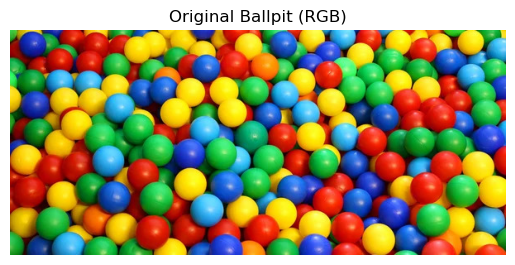

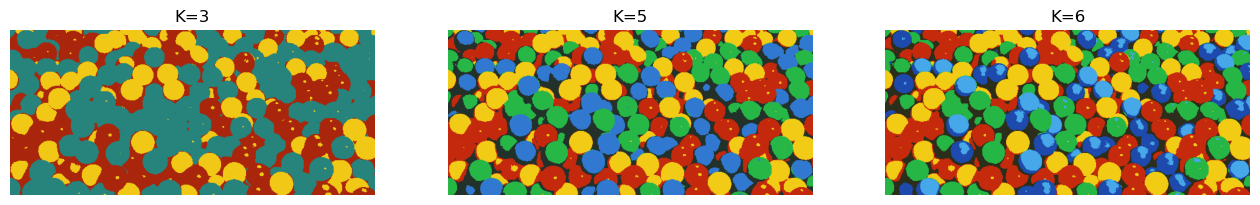

In [3]:
# Load ballpit image
ballpit_bgr, image_opencv = imread_rgb(BALLPIT_PATH)  # image_opencv is RGB for display
plt.imshow(image_opencv); plt.title("Original Ballpit (RGB)"); plt.axis('off'); plt.show()

# Prepare data for k-means: (H*W, 3) float32
Z = image_opencv.reshape((-1, 3)).astype(np.float32)

criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 0.1)
attempts = 10
flags = cv2.KMEANS_RANDOM_CENTERS

def run_kmeans(Z, K):
    compactness, labels, centers = cv2.kmeans(Z, K, None, criteria, attempts, flags)
    centers = np.uint8(centers)
    segmented = centers[labels.flatten()]
    segmented = segmented.reshape(image_opencv.shape)
    return segmented, compactness

seg3, c3 = run_kmeans(Z, 3)
seg5, c5 = run_kmeans(Z, 5)
seg6, c6 = run_kmeans(Z, 6)

fig, ax = plt.subplots(1, 3, figsize=(16,5))
ax[0].imshow(seg3); ax[0].set_title("K=3"); ax[0].axis('off')
ax[1].imshow(seg5); ax[1].set_title("K=5"); ax[1].axis('off')
ax[2].imshow(seg6); ax[2].set_title("K=6"); ax[2].axis('off')
plt.show()



---
## Question 2 : Mean Shift Segmentation

**Task**  
- Apply `cv2.pyrMeanShiftFiltering` to the original ballpit image.
- Try **at least three** `(sp, sr)` settings and display them **side by side**, along with the original for comparison.



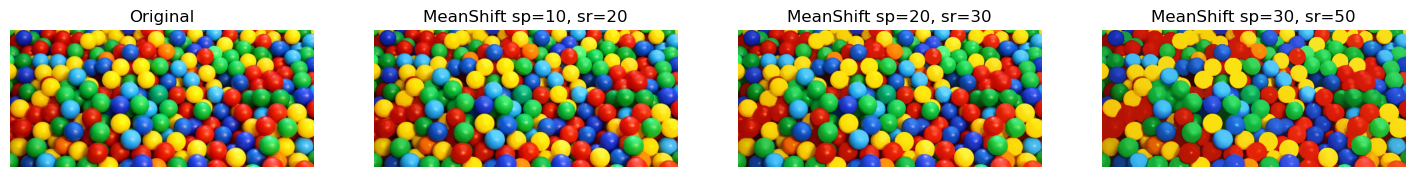

In [4]:
# Mean Shift expects BGR input; we'll convert results back to RGB for display
def mean_shift_rgb(rgb, sp, sr):
    bgr = cv2.cvtColor(rgb, cv2.COLOR_RGB2BGR)
    filtered = cv2.pyrMeanShiftFiltering(bgr, sp=sp, sr=sr)
    return cv2.cvtColor(filtered, cv2.COLOR_BGR2RGB)

settings = [(10, 20), (20, 30), (30, 50)]  # (sp, sr) triplets to compare

outputs = [mean_shift_rgb(image_opencv, sp, sr) for (sp, sr) in settings]

fig, ax = plt.subplots(1, 4, figsize=(18,5))
ax[0].imshow(image_opencv); ax[0].set_title("Original"); ax[0].axis('off')
for i, (sp, sr) in enumerate(settings, start=1):
    ax[i].imshow(outputs[i-1]); ax[i].set_title(f"MeanShift sp={sp}, sr={sr}"); ax[i].axis('off')
plt.show()


---
## Question 3

**Use image:** `'/anvil/projects/tdm/data/yelp/data/photos/lSMrFQi19GpHLI5yuHmnnw.jpg'`  
**Steps:**  
1. Gaussian Blur (5x5)  
2. Grayscale  
3. Binarize with `cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU`  
4. Morphological opening (3x3 kernel, 2 iterations) and then **dilation** (3x3, 3 iterations) to get background regions  
Display the image after each step and discuss which parts were affected by morphology.


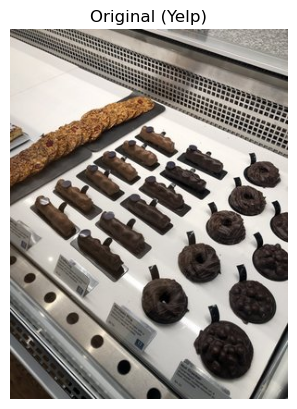

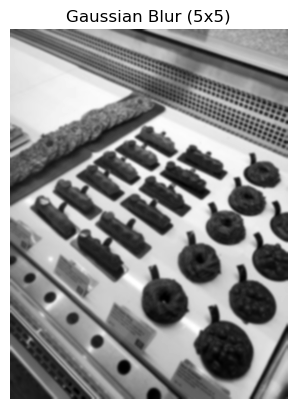

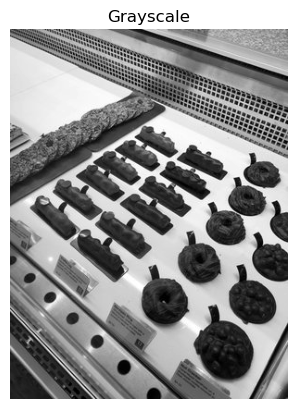

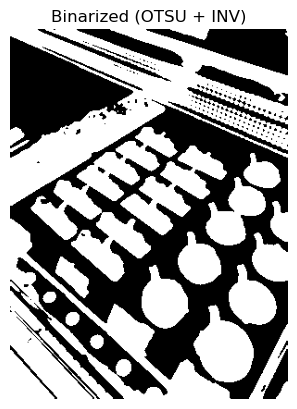

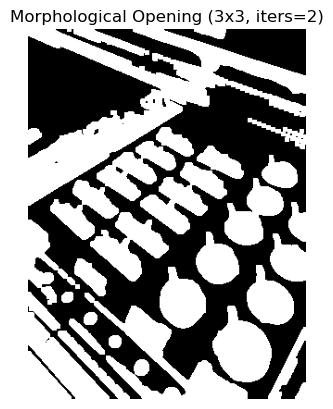

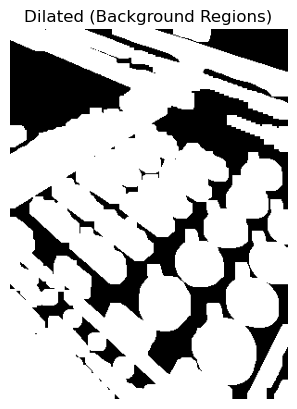

In [6]:

# Load Yelp image (BGR, RGB, GRAY)
yelp_bgr = cv2.imread(YELP_PATH)
yelp_rgb = cv2.cvtColor(yelp_bgr, cv2.COLOR_BGR2RGB)
yelp_gray = cv2.cvtColor(yelp_bgr, cv2.COLOR_BGR2GRAY)

plt.imshow(yelp_rgb); plt.title("Original (Yelp)"); plt.axis('off'); plt.show()

# 1) Gaussian blur (5x5)
blur = cv2.GaussianBlur(yelp_gray, (5,5), 0)
plt.imshow(blur, cmap='gray'); plt.title("Gaussian Blur (5x5)"); plt.axis('off'); plt.show()

# 2) Grayscale already computed as yelp_gray above (shown alongside blur for clarity)
plt.imshow(yelp_gray, cmap='gray'); plt.title("Grayscale"); plt.axis('off'); plt.show()

# 3) Binarize: OTSU + INV
_, binary_inv = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
plt.imshow(binary_inv, cmap='gray'); plt.title("Binarized (OTSU + INV)"); plt.axis('off'); plt.show()

# 4) Morphological opening then dilation
kernel = np.ones((3,3), np.uint8)
opening = cv2.morphologyEx(binary_inv, cv2.MORPH_OPEN, kernel, iterations=2)
plt.imshow(opening, cmap='gray'); plt.title("Morphological Opening (3x3, iters=2)"); plt.axis('off'); plt.show()

background = cv2.dilate(opening, kernel, iterations=3)
plt.imshow(background, cmap='gray'); plt.title("Dilated (Background Regions)"); plt.axis('off'); plt.show()




---
## Question 4 Watershed 

**Steps:**  
5. Distance Transform on the morphological result (opening)  
6. Re-binarize (OTSU) to obtain **sure foreground**  
7. Compute **unknown regions** as `background - foreground`  
Display images after each step. Discuss how the distance map relates to the flooding analogy.


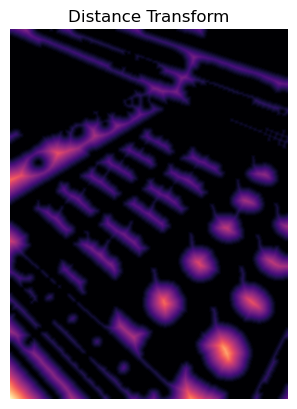

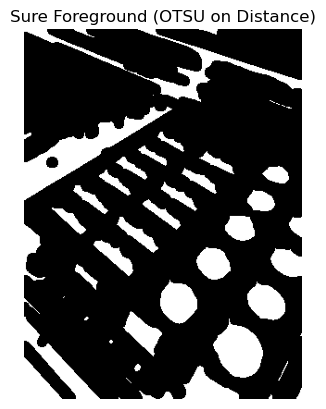

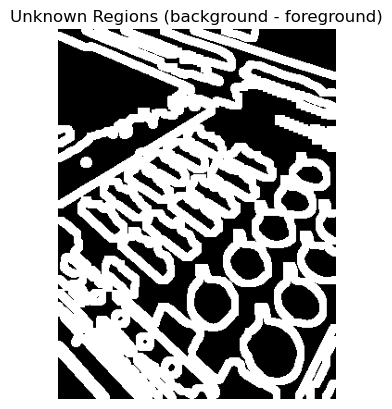

In [9]:
# 5) Distance Transform on the opening result
dist = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
plt.imshow(dist, cmap='magma'); plt.title("Distance Transform"); plt.axis('off'); plt.show()

# Normalize for visualization (optional)
# dist_norm = cv2.normalize(dist, None, 0, 255, cv2.NORM_MINMAX)
# plt.imshow(dist_norm.astype(np.uint8), cmap='magma'); plt.title("Distance Transform (normalized)"); plt.axis('off'); plt.show()

# 6) Re-binarize via OTSU to get sure foreground; need uint8
dist_uint8 = cv2.normalize(dist, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
_, sure_fg = cv2.threshold(dist_uint8, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
plt.imshow(sure_fg, cmap='gray'); plt.title("Sure Foreground (OTSU on Distance)"); plt.axis('off'); plt.show()

# 7) Unknown regions: background - foreground
unknown = cv2.subtract(background, sure_fg)
plt.imshow(unknown, cmap='gray'); plt.title("Unknown Regions (background - foreground)"); plt.axis('off'); plt.show()


---
## Question 5  Watershed — Markers & Final Segmentation

**Steps:**  
- Create markers using `cv2.connectedComponents(sure_fg)`  
- Add 1 to markers; set unknown region to 0  
- Apply `cv2.watershed` on the **original color** image  
- Mark boundaries (`markers == -1`) in **red** on the original image  
Display: markers image, watershed-labeled result, and original with red boundaries. Discuss performance.


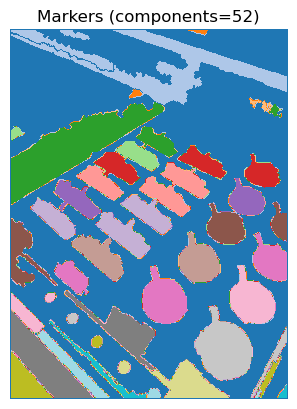

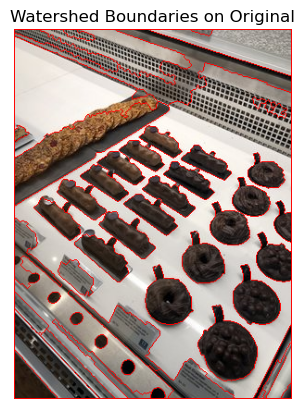

In [8]:

# Connected components on sure foreground
num_labels, markers = cv2.connectedComponents(sure_fg)
# Increment markers so background is not 0
markers = markers + 1
# Mark unknown regions as 0
markers[unknown == 255] = 0

# Watershed modifies markers in-place; use a copy of original color image
ws_input = yelp_bgr.copy()
cv2.watershed(ws_input, markers)  # After this, boundaries are marked with -1 in `markers`

# Visualize markers (random color map for components)
markers_vis = (markers.astype(np.float32) / markers.max()) if markers.max() > 0 else markers.astype(np.float32)
plt.imshow(markers_vis, cmap='tab20')
plt.title(f"Markers (components={num_labels})")
plt.axis('off')
plt.show()

# Overlay boundaries on original RGB
ws_rgb = yelp_rgb.copy()
ws_rgb[markers == -1] = [255, 0, 0]  # red boundaries
plt.imshow(ws_rgb)
plt.title("Watershed Boundaries on Original")
plt.axis('off')
plt.show()
